In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# CUSTOMERS

1) First of all, we import our dataset about customers. We have the unique identifier for each customer and its age. Furthermore, we know whether he or she is subscribed to the newsletter (1 if yes, 0 if no) and if he or she is part of the special club member.

We have a look to how data are structured, printing the first five items and we get a general idea of the quantity of the data, using the shape function.

In [2]:
customers = pd.read_csv("recsys_customers.csv")
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44.0
1,1,1,1,33.0
2,2,0,0,29.0
3,3,0,0,21.0
4,4,0,0,23.0


In [3]:
customers.shape

(41253, 4)

2) We want to find the columns that may have NaN values in order to handle them.

In [4]:
customers.isnull().sum()

customer_id       0
fashion_news      0
club_member       0
age             133
dtype: int64

Out of 4 columns, only 1 column has null values, which is age. 

To understand better the weight of these null values on the whole set, we can calculate their weight relative to the length of the dataset.

In [5]:
null_percentage= customers['age'].isnull().sum()/ len(customers)
print('The null percentage of age is: ' + str(null_percentage))

The null percentage of age is: 0.0032240079509369014


The percentage of missing values is quite low, around 0.32%. 
At this point we can choose to follow 2 paths:
- Delete all the rows that contain a null value for age.
- We can fill the null cells with the most common values for age.

We decided to proceed by substituting all NaN values with the mode of the values of age, which is 26.

In [6]:
customers.age.mode()

0    26.0
Name: age, dtype: float64

In [7]:
customers['age'] = customers['age'].fillna(customers['age'].mode()[0])

3) As we want our data to be as readable and interpretable as possible, we want to convert the age type from float to integer.

In [8]:
customers["age"] = customers["age"].apply(lambda x: int(x))
customers.head()

,customer_id,fashion_news,club_member,age
0,0,1,1,44
1,1,1,1,33
2,2,0,0,29
3,3,0,0,21
4,4,0,0,23


4) To get a better insight of our data we want to divide customers in 5 categories depending on their age. 

To simplify things, we calculate the maximum and minimum of the age values and then we create our "clusters".

In [9]:
print('The minimum age recorded is: ' + str(min(customers["age"])))
print('The maximum age recorded is: ' + str(max(customers["age"])))

The minimum age recorded is: 16
The maximum age recorded is: 91


What are we doing? We assign each customer to the proper age category adding a column to the initial table.

In [10]:
bins = [15, 22, 31, 51, 70, 92]
groups = ['15-21', '22-30', '31-50','51-69', '70+']

customers['age_group'] = pd.cut(customers.age, bins, labels = groups, include_lowest=True)
customers

,customer_id,fashion_news,club_member,age,age_group
0,0,1,1,44,31-50
1,1,1,1,33,31-50
2,2,0,0,29,22-30
3,3,0,0,21,15-21
4,4,0,0,23,22-30
...,...,...,...,...,...
41248,41248,1,1,33,31-50
41249,41249,0,0,25,22-30
41250,41250,1,1,20,15-21
41251,41251,1,1,29,22-30


After that we have categorized each customer, we can start to count how many members belong to each category. We do this using the group by function. Obviously, the total number of the members in each category is equal to the length of the dataset.

In [11]:
age_group_counts = customers.groupby('age_group').size()
age_group_counts

age_group
15-21     4906
22-30    16964
31-50    13288
51-69     5922
70+        173
dtype: int64

In [12]:
''' same as doing
from collections import Counter 
age_group_counts2 = Counter(customers['age_group'])
age_group_counts2 '''

" same as doing\nfrom collections import Counter \nage_group_counts2 = Counter(customers['age_group'])\nage_group_counts2 "

5) We are know ready to plot our age groups into a barplot to see the hetereogeneity of our dataset. In fact, as we expected, there are much more younger customers with respect to older ones.

In [13]:
age_group_counts_df = pd.DataFrame([age_group_counts]).T.reset_index()
age_group_counts_df.columns = ['Age Group', 'Count']
age_group_counts_df

,Age Group,Count
0,15-21,4906
1,22-30,16964
2,31-50,13288
3,51-69,5922
4,70+,173


6) We can plot our results to better capture the age distribution of our data. In our dataset there are much more people under 50 years old with respect to people over 50.
The percentage of people below 50 years old is 85.2%!!!

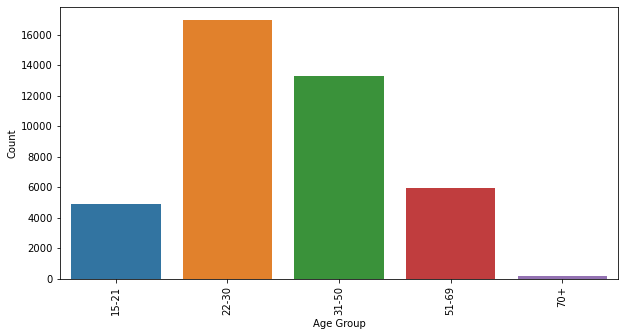

In [14]:
plt.figure(figsize=(10,5))
sns.barplot(x='Age Group', y='Count', data=age_group_counts_df)
plt.xticks(rotation=90)
plt.show()

In [15]:
people_under_50 = age_group_counts[0]+age_group_counts[1]+age_group_counts[2]
people_over_50 = age_group_counts[3]+age_group_counts[4]
total_number_customers = people_under_50 + people_over_50
print(f'The percentage of people under 50 years old is: {( people_under_50 / total_number_customers) }')

The percentage of people under 50 years old is: 0.852253169466463


7) Actually, it would be better for us also to capture how many people inside each age group have agreed to be part in the member club and how many people have activated the fashion news.

We know that both columns of 'club member' and 'fashion news' have two possible values:
- 1 if the customer is subscribed to the club member or to fashion news
- 0 if the customer is not subscribed

#### Club membership

In [16]:
from collections import Counter

club_general = Counter(customers['club_member'])
club_general

Counter({1: 17975, 0: 23278})

We create a dataframe that contains the two options (being subscribed or not being subscribed) and we count how many customers there are in each of them.

In [17]:
club_general_df = pd.DataFrame([club_general]).T.reset_index()
club_general_df.columns = ['Premium Club (1=yes, 0=no)', 'Count']
club_general_df

,"Premium Club (1=yes, 0=no)",Count
0,1,17975
1,0,23278


We plot the graph of the dataframe. However it does not tell us a lot because we do not know to which group age each customer belongs. Therefore, we might decide to create a more accurate dataframe which always categorizes customers in two classes (subscribed or not subscribed) but at the same time, clusters the clients also by age group. In this way we can capture more information.

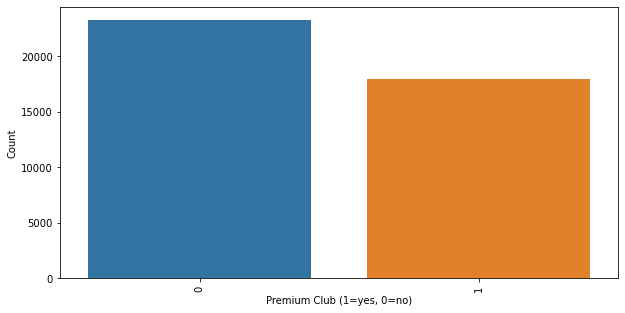

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(x='Premium Club (1=yes, 0=no)', y='Count', data=club_general_df)
plt.xticks(rotation=90)
plt.show()

In [19]:
club_member_df = customers.groupby(['age_group', 'club_member']).count().reset_index()
club_member_df = club_member_df.drop(columns=['fashion_news', 'age'])
club_member_df.columns = ['age_group', 'club_member', 'count']
club_member_df

,age_group,club_member,count
0,15-21,0,2479
1,15-21,1,2427
2,22-30,0,10441
3,22-30,1,6523
4,31-50,0,7414
5,31-50,1,5874
6,51-69,0,2876
7,51-69,1,3046
8,70+,0,68
9,70+,1,105


For instance, on average there are more people which are not subscribed to the premium club. However, most of the people who are subscribed are youngsters. For what concerns elderly people, their percentage of influence in the dataset is very small.

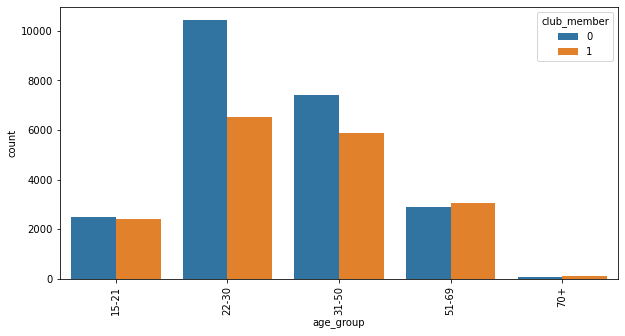

In [20]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='club_member', data=club_member_df)
plt.xticks(rotation=90)
plt.show()

#### Fashion news

In [21]:
from collections import Counter
fashion_general = Counter(customers['fashion_news'])

fashion_general_df = pd.DataFrame([fashion_general]).T.reset_index()
fashion_general_df.columns = ['Fashion News (1=yes, 0=no)', 'Count']
fashion_general_df

,"Fashion News (1=yes, 0=no)",Count
0,1,18213
1,0,23040


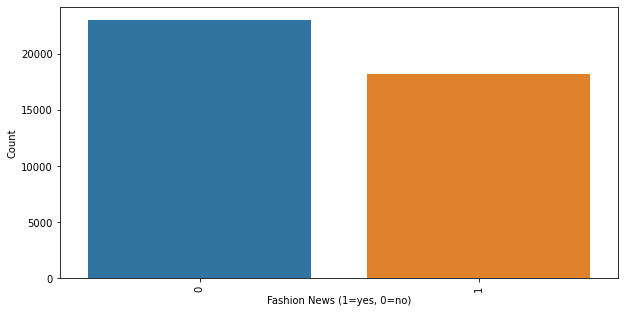

In [22]:
plt.figure(figsize=(10,5))
sns.barplot(x='Fashion News (1=yes, 0=no)', y='Count', data=fashion_general_df)
plt.xticks(rotation=90)
plt.show()

In [23]:
fashion_news_df = customers.groupby(['age_group', 'fashion_news']).count().reset_index()
fashion_news_df = fashion_news_df.drop(columns=['club_member', 'age'])
fashion_news_df.columns = ['age_group', 'fashion_news', 'count']
fashion_news_df

,age_group,fashion_news,count
0,15-21,0,2420
1,15-21,1,2486
2,22-30,0,10351
3,22-30,1,6613
4,31-50,0,7354
5,31-50,1,5934
6,51-69,0,2847
7,51-69,1,3075
8,70+,0,68
9,70+,1,105


From the graph underneath, we can see again that yougsters are a vast majority of members connected to fashion news. However, the probability that a person over 60 is connected to fashion news is higher to not being connected with respect to younger people.

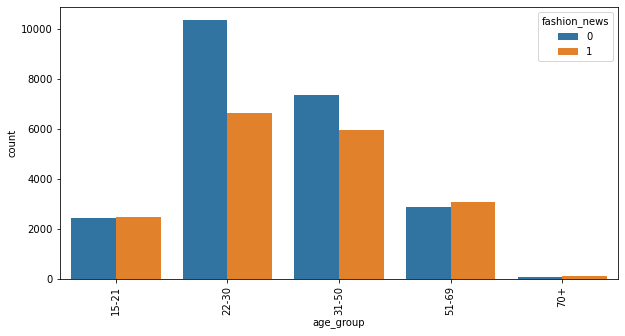

In [24]:
plt.figure(figsize=(10,5))
sns.barplot(x='age_group', y='count', hue='fashion_news', data=fashion_news_df)
plt.xticks(rotation=90)
plt.show()

As a conclusion, what useful information can we use for our recommendation system?
- Data of customers in the cutomers' dataset is not very homogeneous (85% of the population is below 50 years old).
- People over 50 years old have an higher probability to be subscribed to fashion news and member club with respect to people under 50 years old.
- In general there are more people who are not into these activities.

# ARTICLES

In the second part of our data analysis, we will study the different articles that our company sells. The final aim is to be able to understand when different articles are similiar or different and therefore, when to suggest one of them basing on the previous orders. 
Let's take a look to this dataset:

In [25]:
articles = pd.read_csv("recsys_articles.csv")
articles

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,perceived_colour_master_name,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
0,0,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
1,1,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
2,2,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
3,3,200 den 1p Tights,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
4,4,Control Top 50 den 1p Tights,273,Leggings/Tights,Garment Lower body,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,6531,Virgo sweater fast buy,252,Sweater,Garment Upper body,9,Black,4,Dark,5,Black,1640,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy
6532,6532,Virgo sweater fast buy,252,Sweater,Garment Upper body,52,Pink,1,Dusty Light,4,Pink,1640,Tops Fancy Jersey,D,Divided,2,Divided,53,Divided Collection,1005,Jersey Fancy
6533,6533,Heavy plain overknee tights 1p,304,Underwear Tights,Socks & Tights,9,Black,4,Dark,5,Black,3608,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights
6534,6534,SPORT Malaga tank,253,Vest top,Garment Upper body,9,Black,4,Dark,5,Black,1919,Jersey,A,Ladieswear,1,Ladieswear,2,H&M+,1005,Jersey Fancy


As we can easily see, this dataset has a more complex structure than the one analyzed before, but we can for sure ignore some columns.
Each category is represented by two columns and for this reason, we can take only one and discard the other.
For example, each product has the variable 'product_type' containing its ID code and the variable 'product_type_name' that is the full name of the product.
Therefore, we can choose some variables to consider and someother to ignore.

1) As we did for customers, we want to check how many values are null. Luckily, this time we have zero null values.

In [26]:
articles.isnull().sum()

article_id                      0
prod_name                       0
product_type                    0
product_type_name               0
product_group_name              0
colour_group                    0
colour_group_name               0
perceived_colour_value          0
perceived_colour_value_name     0
perceived_colour_master         0
perceived_colour_master_name    0
department                      0
department_name                 0
index                           0
index_name                      0
index_group                     0
index_group_name                0
section                         0
section_name                    0
garment_group                   0
garment_group_name              0
dtype: int64

2) Now we can group our articles in different ways, starting from the division in categories.

#### CATEGORIES

We want to see how our products are partitioned according to their category. We analyze how these categories are structured and we find the number of articles for each of them.

From the dataframe, we see that the product type with more articles is 'Trousers', with exactly 972 models.

In [27]:
type_article_count = Counter(articles['product_type_name'])
type_article_count_df = pd.DataFrame([type_article_count]).T.reset_index()
type_article_count_df.columns = ['Type', 'Count']
type_article_count_df = type_article_count_df.sort_values(by='Count', ascending=False) #We sort the dataframe in order to see the biggest types without any code

Let's see a visual representation:

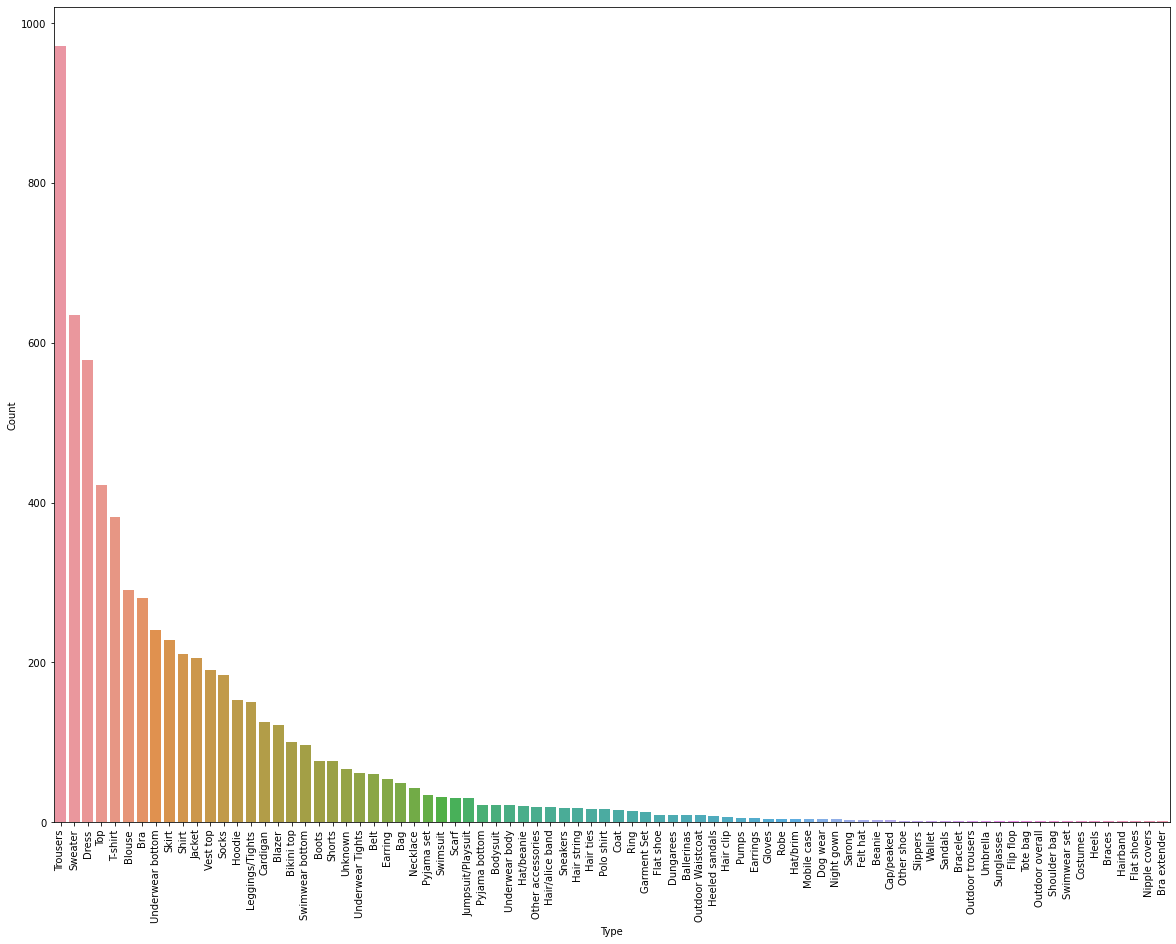

In [28]:
plt.figure(figsize=(20,15))
sns.barplot(x='Type', y='Count', data=type_article_count_df)
plt.xticks(rotation=90)
plt.show()

The plot underneath is useful, but also too caothic (82 categories are too many). A great solution is to regroup our categories (types) in some larger categories, represented by groups.

#### GROUPS

In [29]:
group_article_count = Counter(articles['product_group_name'])
group_article_count_df = pd.DataFrame([group_article_count]).T.reset_index()
group_article_count_df.columns = ['Group', 'Count']
group_article_count_df = group_article_count_df.sort_values(by='Count', ascending=False)
group_article_count_df

,Group,Count
3,Garment Upper body,2799
1,Garment Lower body,1428
7,Garment Full body,632
4,Underwear,547
6,Accessories,378
0,Socks & Tights,245
9,Swimwear,233
8,Shoes,135
5,Unknown,67
10,Nightwear,60


This time, we directly see all the classification for groups, where the winner is Garment Upper body, with 2799 different articles. Here we have a simpler plot where we can immediately see all the categories. In this way, the data is more interpretable and even more useful for our aims. Once more, we plot our results:

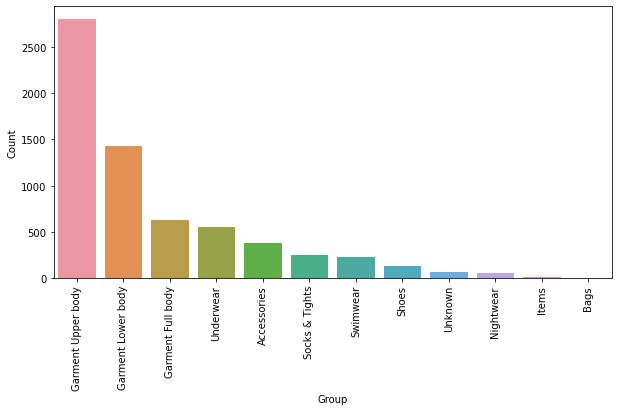

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(x='Group', y='Count', data=group_article_count_df)
plt.xticks(rotation=90)
plt.show()

In [86]:
type_article_count = Counter(articles['product_type_name'])
type_article_count_df = pd.DataFrame([type_article_count]).T.reset_index()
type_article_count_df.columns = ['Type', 'Count']
type_article_count_df = type_article_count_df.sort_values(by='Count', ascending=False)
#type_article_count_df
#82 rows

In [84]:
group_article_count = Counter(articles['product_group_name'])
group_article_count_df = pd.DataFrame([group_article_count]).T.reset_index()
group_article_count_df.columns = ['Group', 'Count']
group_article_count_df = group_article_count_df.sort_values(by='Count', ascending=False)
#group_article_count_df
#12 rows

In [62]:
department_count = Counter(articles['department_name'])
department_count_df = pd.DataFrame([department_count]).T.reset_index()
department_count_df.columns = ['Department', 'Count']
department_count_df = department_count_df.sort_values(by='Count', ascending=False)
#182 rows

In [65]:
index_group = Counter(articles['index_group_name'])
index_group_df = pd.DataFrame([index_group]).T.reset_index()
index_group_df.columns = ['Index Group', 'Count']
index_group_df = index_group_df.sort_values(by='Count', ascending=False)
#5 rows

In [66]:
section_count = Counter(articles['section_name'])
section_count_df = pd.DataFrame([section_count]).T.reset_index()
section_count_df.columns = ['Section', 'Count']
section_count_df = section_count_df.sort_values(by='Count', ascending=False)
#section_count_df
#43 rows

In [36]:
garment_group = Counter(articles['garment_group'])
garment_group_df = pd.DataFrame([garment_group]).T.reset_index()
garment_group_df.columns = ['Garment Group', 'Count']
garment_group_df = garment_group_df.sort_values(by='Count', ascending=False)
#21 rows

#### UNKNOWN GROUPS

Unfortunately, from this last plot, we can see that not all the articles belong to a group. We want to identify them:

In [37]:
unknowns = articles.loc[articles['product_group_name'] == 'Unknown']

It may be interesting to understand which departments have more unknown items.

In [38]:
department_count = Counter(unknowns['department_name'])
department_count_df = pd.DataFrame([department_count]).T.reset_index()
department_count_df.columns = ['Department', 'Unknown products found']
department_count_df = department_count_df.sort_values(by='Unknown products found', ascending=False)

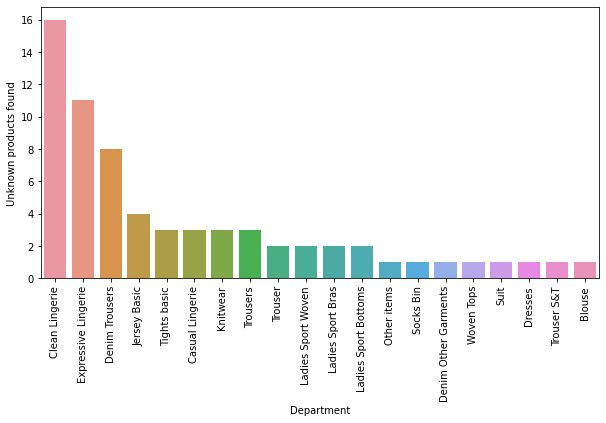

In [39]:
plt.figure(figsize=(10,5))
sns.barplot(x='Department', y='Unknown products found', data=department_count_df)
plt.xticks(rotation=90)
plt.show()

Clean Lingerie's department has the biggest number of unknown items. 

#### COLOURS

To evaluate the colour of the articles there are several measures: colour_group, perceived_colour_value and perceived_colour_master. For our analysis we are going to consider just the perceived_colour_master because it is a good compromise between making a model having too large scale and doing overfitting. In fact, perceived_colour_value has not enough values (only 7) and colour_group has too many of them making the model too precise.

In [79]:
from collections import Counter
article_colour = Counter(articles['perceived_colour_master_name'])
del article_colour['Unknown']
del article_colour['undefined']

article_colour_df = pd.DataFrame([article_colour]).T.reset_index()
article_colour_df.columns = ['Colour', 'Count']
article_colour_df = article_colour_df.sort_values(by='Colour')
article_colour_df

,Colour,Count
3,Beige,547
0,Black,2134
1,Blue,726
5,Brown,156
13,Green,176
2,Grey,526
7,Khaki green,218
10,Lilac Purple,108
9,Metal,116
6,Mole,177


In [57]:
from collections import Counter
article_colour2 = Counter(articles['colour_group'])

article_colour2_df = pd.DataFrame([article_colour2]).T.reset_index()
article_colour2_df.columns = ['Colour', 'Count']
article_colour2_df = article_colour2_df.sort_values(by='Colour')

In [58]:
from collections import Counter
article_colour3 = Counter(articles['perceived_colour_value'])

article_colour3_df = pd.DataFrame([article_colour3]).T.reset_index()
article_colour3_df.columns = ['Colour', 'Count']
article_colour3_df = article_colour3_df.sort_values(by='Colour')

# TRANSACTIONS

In [43]:
transactions = pd.read_csv("recsys_transactions.csv")
transactions.head()

,t_dat,customer_id,article_id
0,2020-09-02,7,599
1,2020-09-02,7,2600
2,2020-09-02,7,2063
3,2020-09-02,7,5188
4,2020-09-02,17,5111


The last dataset we are going to study is "recsys_transactions.csv". The information about transactions that is recorded in the table is: the date of purchase, the customer id and the product id. The same customer can purchase more articles.

To be in no doubt, we check if there are Null values that might interfere with our analysis.

In [44]:
transactions.isnull().sum()

t_dat          0
customer_id    0
article_id     0
dtype: int64

This result was not hard to predict.
Indeed, looking to this dataset, we observe that it is based on a relationship between the other 2 datasets. As a consequence, all the rows are composed by the IDs of an article and the IDs of a costumer.
Without one of these 2 values, the row will give us zero relevant information, being useless to process it.

We can also see which is the day with the most number of transactions. 
The day with the biggest number of transactions is the 13th of september 2020, which was a Sunday.

In [45]:
day_count = Counter(transactions['t_dat'])
day_count_df = pd.DataFrame([day_count]).T.reset_index()
day_count_df.columns = ['Day', 'Count']
day_count_df = day_count_df.sort_values(by='Count', ascending=False)
day_count_df

,Day,Count
11,2020-09-13,21209
7,2020-09-09,21155
15,2020-09-17,20458
8,2020-09-10,19531
5,2020-09-07,19473
16,2020-09-18,19129
3,2020-09-05,18990
10,2020-09-12,18926
1,2020-09-03,18557
6,2020-09-08,18535


#### Number of transactions per customer

We would like to see how many purchases has done each customer. We create a dataframe with 2 columns: on one side the customer ID and on the other the number of purchases each customer has made.

In [46]:
from collections import Counter
customer_transactions_count = Counter(transactions['customer_id'])
#transactions.groupby('customer_id').size()
#outputs a long dictionary with key the id of the customer and value the number of purchases he or she has made

In [47]:
customer_transactions_count_df = pd.DataFrame([customer_transactions_count]).T.reset_index()
customer_transactions_count_df.columns = ['Customer ID', 'Number of Transactions']
#customer_transactions_count_df= customer_transactions_count_df.sort_values(by='Customer ID', ascending=True).reset_index()
customer_transactions_count_df.sort_values(by='Number of Transactions', ascending=False)

,Customer ID,Number of Transactions
38291,9197,104
35275,36953,95
4445,16472,92
27086,13753,88
5953,33914,85
...,...,...
31161,24874,1
4048,11884,1
12285,36144,1
12292,36223,1


The customer who has ultimated the highest amount of purchases is the user '9197' with exactly 104 transactions. Sorting in descending order, we are able to see also a ranking based on transactions for users.

#### Number of customers that has bought each prooduct

It is also interesting to see everything on the other way around, so how many times each item has been bought by customers.

In [48]:
article_transactions_count = Counter(transactions['article_id'])

In [49]:
article_transactions_count_df = pd.DataFrame([article_transactions_count]).T.reset_index()
article_transactions_count_df.columns = ['Article ID', 'Number of Transactions']
article_transactions_count_df.sort_values(by='Number of Transactions', ascending=False)

,Article ID,Number of Transactions
48,1419,1045
927,168,896
63,5831,889
1359,6166,858
318,1429,815
...,...,...
2651,1692,11
4160,5324,11
2689,2536,11
2692,2625,11


#### ANALYSIS

From the above dataframe we are able to get which is the most requested article.
By looking for its id in the articles dataset, we can access to a wider range of information with respect to the case we studied before.
This happens because for customers we cannot access to all the information we would need to make a more in-dept analysis because most of the information is sensitive data. Whereas, for products we can see more information useful for market strategies.
So, let'see what is this 'id 1419':

In [50]:
articles.loc[articles['article_id'] == 1419]

,article_id,prod_name,product_type,product_type_name,product_group_name,colour_group,colour_group_name,perceived_colour_value,perceived_colour_value_name,perceived_colour_master,perceived_colour_master_name,department,department_name,index,index_name,index_group,index_group_name,section,section_name,garment_group,garment_group_name
1419,1419,Pluto RW slacks (1),272,Trousers,Garment Lower body,9,Black,4,Dark,5,Black,1722,Trouser,A,Ladieswear,1,Ladieswear,15,Womens Everyday Collection,1009,Trousers


This row gives us a lot of information, maybe too much.
In fact, in our opinion, is better to focus on category in spite of single products, because we can have a more accurate analysis basing on a bigger radius of articles, avoiding in this way some outliers.

In [51]:
article_type_dict = {}
article_group_dict = {}

for i,row in articles.iterrows():
    article_type_dict[row['article_id']] = row['product_type_name']
    article_group_dict[row['article_id']] = row['product_group_name']

In [52]:
type_transactions = {}
for i,row in transactions.iterrows():
    if article_type_dict[row['article_id']] in type_transactions.keys():
        type_transactions[article_type_dict[row['article_id']]] += 1
    else:
        type_transactions[article_type_dict[row['article_id']]] = 1
        
type_transactions_df = pd.DataFrame({'Type of products':list(type_transactions.keys()),'Number of Transactions':list(type_transactions.values())})
type_transactions_df = type_transactions_df.sort_values(by='Number of Transactions', ascending = False)
type_transactions_df

,Type of products,Number of Transactions
5,Trousers,65295
11,Sweater,49602
2,Top,28308
3,Dress,26333
23,T-shirt,21010
...,...,...
69,Swimwear set,16
71,Braces,15
75,Flip flop,14
78,Heels,13


Thanks to this frame we can see that the most sold type of product is 'Trousers', with a huge gap from the second one. This is probably caused by the fact that trousers is also the type of product with more different articles inside.

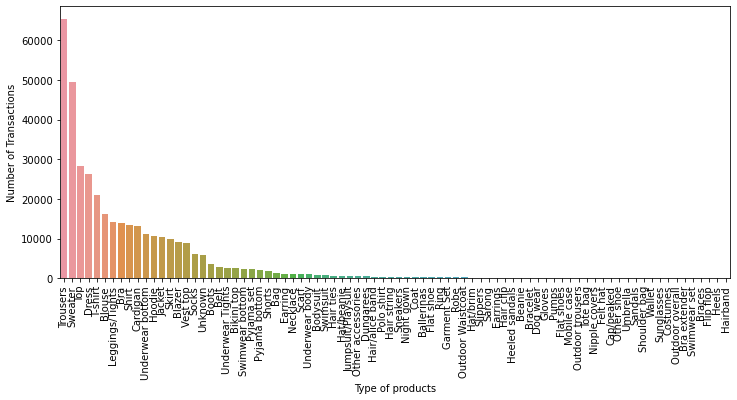

In [53]:
plt.figure(figsize=(12,5))
sns.barplot(x='Type of products', y='Number of Transactions', data=type_transactions_df)
plt.xticks(rotation=90)
plt.show()

Now let's do the same analysis but, this time, focusing on the group of articles.

In [54]:
group_transactions = {}
for i,row in transactions.iterrows():
    if article_group_dict[row['article_id']] in group_transactions.keys():
        group_transactions[article_group_dict[row['article_id']]] += 1
    else:
        group_transactions[article_group_dict[row['article_id']]] = 1
        
group_transactions_df = pd.DataFrame({'Group of products':list(group_transactions.keys()),'Number of Transactions':list(group_transactions.values())})
group_transactions_df.sort_values(by='Number of Transactions', ascending = False)

,Group of products,Number of Transactions
1,Garment Upper body,182576
3,Garment Lower body,91015
2,Garment Full body,27687
0,Underwear,26365
4,Accessories,11335
7,Socks & Tights,8701
8,Unknown,5847
6,Swimwear,5686
5,Shoes,4977
9,Nightwear,4623


And one more time, we got the expexted result, since 'Garment Upper body' is the most populate group.
In this case, the distance between the top group and the others is incredibly huge (It is the double of the second ranked group).

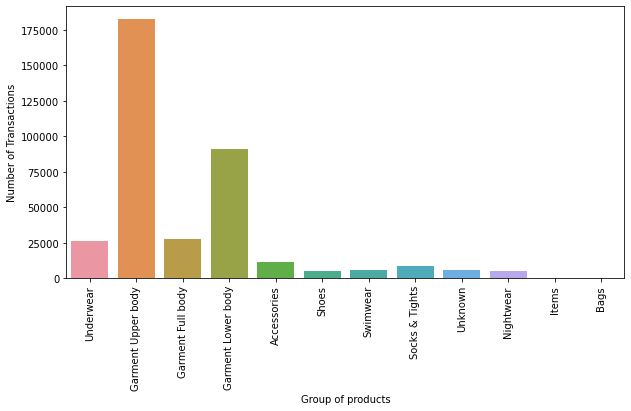

In [55]:
plt.figure(figsize=(10,5))
sns.barplot(x='Group of products', y='Number of Transactions', data=group_transactions_df)
plt.xticks(rotation=90)
plt.show()

# CONTENT-BASED FILTERING RECOMMENDER

We can now start to build the content-based filtering recommender. We begin by setting up our dataset in such a way that rows represent all the articles and columns represent the features we are interested in.

1) First, we create a table whose columns are all the values present in the column 'perceived_colour_master_name' and the rows are all the articles. The values inside the table are '1' if the cloth in the corresponding row has the colour of the respective column, else it has a '0'.

In [80]:
#create a one hot encoding
colours = list(article_colour.keys())
for c in colours:
    articles[c] = articles['perceived_colour_master_name'].transform(lambda x: int(c in x))
articles[colours]

,Black,Blue,Grey,Beige,White,Brown,Mole,Khaki green,Red,Metal,Lilac Purple,Yellow,Pink,Green,Orange,Turquoise
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6532,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6533,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6534,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


We do the same for 'section name' and 'product_type_name'.

In [82]:
section_count = Counter(articles['section_name'])
sections = list(section_count.keys())
for s in sections:
    articles[s] = articles['section_name'].transform(lambda x: int(s in x))
articles[sections]

,"Womens Nightwear, Socks & Tigh",Womens Small accessories,Men H&M Sport,Womens Lingerie,Womens Everyday Basics,Womens Big accessories,Divided Basics,Girls Underwear & Basics,H&M+,Mama,Men Underwear,Ladies Denim,Young Boy,Divided Selected,Men Accessories,Womens Shoes,"Womens Swimwear, beachwear",Men Suits & Tailoring,Womens Jackets,Womens Everyday Collection,Contemporary Street,Boys Underwear & Basics,Divided Collection,Ladies H&M Sport,Baby Essentials & Complements,Mens Outerwear,Womens Tailoring,Womens Casual,Contemporary Casual,Kids Boy,Womens Trend,Contemporary Smart,Womens Premium,Denim Men,Divided Asia keys,Divided Projects,Divided Accessories,Kids Girl,Young Girl,Baby Boy,Divided Complements Other,Kids Sports,Baby Girl
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6532,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6533,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6534,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [87]:
type_article_count = Counter(articles['product_type_name'])
types = list(type_article_count.keys())
for t in types:
    articles[t] = articles['product_type_name'].transform(lambda x: int(t in x))
articles[types]

,Underwear Tights,Leggings/Tights,Umbrella,Sweater,Bra,Socks,Unknown,Belt,Hair clip,Hair string,Skirt,Dress,Hoodie,Sunglasses,Underwear bottom,Jacket,Costumes,T-shirt,Trousers,Coat,Polo shirt,Top,Ballerinas,Swimwear bottom,Earring,Felt hat,Bag,Shirt,Shorts,Vest top,Braces,Nipple covers,Hair ties,Bra extender,Bodysuit,Pyjama bottom,Bikini top,Swimsuit,Blazer,Cardigan,...,Boots,Sneakers,Pyjama set,Hat/brim,Scarf,Hat/beanie,Beanie,Swimwear set,Other accessories,Cap/peaked,Hair/alice band,Earrings,Shoulder bag,Jumpsuit/Playsuit,Necklace,Outdoor overall,Gloves,Robe,Night gown,Tote bag,Flip flop,Outdoor trousers,Pumps,Heeled sandals,Flat shoe,Sarong,Slippers,Ring,Dungarees,Mobile case,Wallet,Sandals,Garment Set,Outdoor Waistcoat,Heels,Other shoe,Hairband,Flat shoes,Dog wear,Bracelet
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6531,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6532,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6533,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6534,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In the following passage, we merge all the information into a unique dataframe.

In [90]:
article_features = pd.concat([articles[colours], articles[sections], articles[types]], axis=1)
article_features.head()

,Black,Blue,Grey,Beige,White,Brown,Mole,Khaki green,Red,Metal,Lilac Purple,Yellow,Pink,Green,Orange,Turquoise,"Womens Nightwear, Socks & Tigh",Womens Small accessories,Men H&M Sport,Womens Lingerie,Womens Everyday Basics,Womens Big accessories,Divided Basics,Girls Underwear & Basics,H&M+,Mama,Men Underwear,Ladies Denim,Young Boy,Divided Selected,Men Accessories,Womens Shoes,"Womens Swimwear, beachwear",Men Suits & Tailoring,Womens Jackets,Womens Everyday Collection,Contemporary Street,Boys Underwear & Basics,Divided Collection,Ladies H&M Sport,...,Boots,Sneakers,Pyjama set,Hat/brim,Scarf,Hat/beanie,Beanie,Swimwear set,Other accessories,Cap/peaked,Hair/alice band,Earrings,Shoulder bag,Jumpsuit/Playsuit,Necklace,Outdoor overall,Gloves,Robe,Night gown,Tote bag,Flip flop,Outdoor trousers,Pumps,Heeled sandals,Flat shoe,Sarong,Slippers,Ring,Dungarees,Mobile case,Wallet,Sandals,Garment Set,Outdoor Waistcoat,Heels,Other shoe,Hairband,Flat shoes,Dog wear,Bracelet
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


2) In order to make the collaborative reccomender system, we can use the cosine similarity, which is a similarity metric.

To give a very quick explanation of the functionality of cosine similarity, it simply looks at the cosine angle between two vectors and the smaller it is, the higher the degree of similarity will be.
The cosine similarity matrix has shape 6536 x 6536, which correspond to the total number of articles.

With the cosine similarity matrix we are able to identify the articles that are more similar to the article of interest.

In [91]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(article_features, article_features)
print(f"Dimensions of our movie features cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our movie features cosine similarity matrix: (6536, 6536)


3) Since we need to have some informations of the product we reccommend, the id of the product is not enough, so we need to create a dictionary that will map for each id the name of the article (in order to be more clear).

In [ ]:
product_dict = {}
for i,row in articles.iterrows():
    product_dict[row['article_id']] = row['prod_name']
product_dict

4) The following function that retrieves the 10 most similar articles to the one that we give as input. The input is the article ID, which is unique.
The function takes the row of the similarity matrix associated to the article ID and we sort the elements in decreasing order. Finally we can take just the items we are interested into.

In [102]:
def get_content_based_recommendations(prod_id, n=10):
    id = articles[articles['article_id'] == prod_id].index
    sim_scores = np.argsort(cosine_sim[id])[0] #returns ID sorted by the values
    sim_scores = sim_scores[::-1][1:n+1] #flip the output to get the IDs in descending order
    print(sim_scores)
    print(f"Recommendations for {priduct_dict[prod_id]} (Id: {prod_id}):")
    print(articles['article_id'].iloc[[i for i in sim_scores]])

In [105]:
prod_name = 20
get_content_based_recommendations(prod_name,10)

[ 703 4673  116   20 2243 2251 2252  661   69 4135]
Recommendations for 20:
703      703
4673    4673
116      116
20        20
2243    2243
2251    2251
2252    2252
661      661
69        69
4135    4135
Name: article_id, dtype: int64
